In [1]:
import sys
sys.path.append('C:\\Users\\caudillo\\examples')

import pydot
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Cargando dataset oxford_iiit_pet
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)



c:\Users\caudillo\anaconda3\envs\nuevo_entorno\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Normalizar colores
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [3]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(
        datapoint['segmentation_mask'],
        (128, 128),
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [4]:
# The dataset already contains the required training and test splits, so continue to use the same splits
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 128
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [5]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [6]:
# The following class performs a simple augmentation by randomly-flipping an image
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal")
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal")

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

# Create an instance of the Augment class
augment_layer = Augment()

In [7]:
# Build the input pipeline, applying the augmentation after batching the inputs
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(lambda x, y: augment_layer(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)

In [8]:
# Visualize an image example and its corresponding mask from the dataset
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

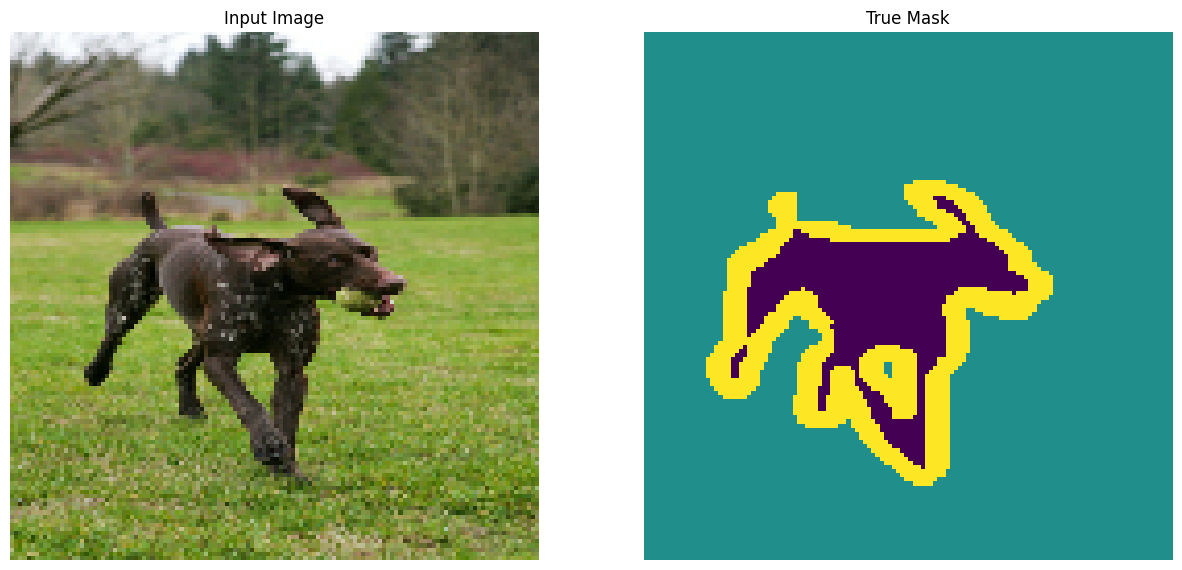

In [9]:
# Muestra un ejemplo de imagen y máscara del conjunto de datos de entrenamiento
for images, masks in train_batches.take(2):  # Toma los primeros 2 lotes de imágenes y máscaras
    sample_image, sample_mask = images[0], masks[0]  # Selecciona la primera imagen y máscara del primer lote
display([sample_image, sample_mask])  # Muestra la imagen y la máscara en una figura


In [10]:
# Define the model
# Encoder: Pre-trained MobileNetV2 model used for feature extraction
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers (encoder layers)
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model (encoder)
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False



In [11]:
# Decoder: A series of upsampling blocks
up_stack = [
    pix2pix.upsample(1024, 3),  # 4x4 -> 8x8
    pix2pix.upsample(512, 3),  # 8x8 -> 16x16
    pix2pix.upsample(256, 3),  # 16x16 -> 32x32
    pix2pix.upsample(128, 3),   # 32x32 -> 64x64
]



In [12]:
def unet_model(output_channels: int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Encoder: Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Decoder: Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # Final layer of the model (decoder)
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  # 64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [13]:
# Train the model
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [15]:
#Eche un vistazo rápido a la arquitectura del modelo resultante:
# Plot the resulting model architecture
plt.figure(figsize=(10, 10))
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plt.show()


AttributeError: module 'pydot' has no attribute 'InvocationException'

<Figure size 1000x1000 with 0 Axes>

In [ ]:
# Try out the model to check what it predicts before training
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:


def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


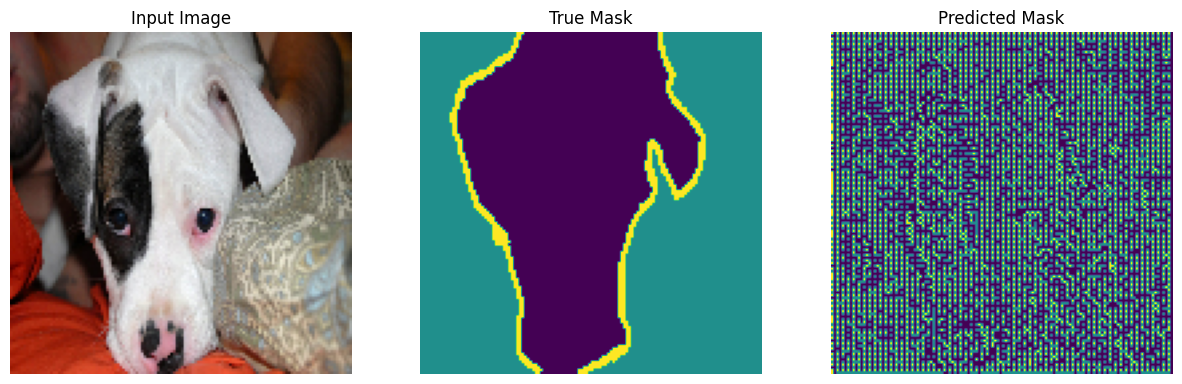

In [ ]:
show_predictions()

In [ ]:
# The callback defined below is used to observe how the model improves while it is training
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


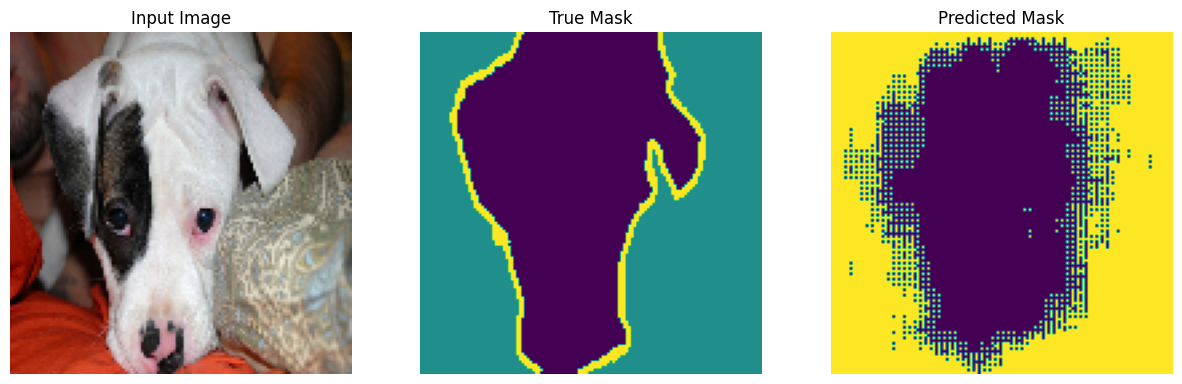


Sample Prediction after epoch 10

28/28 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.6732 - loss: 6.6860 - val_accuracy: 0.7796 - val_loss: 5.4941


In [ ]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])


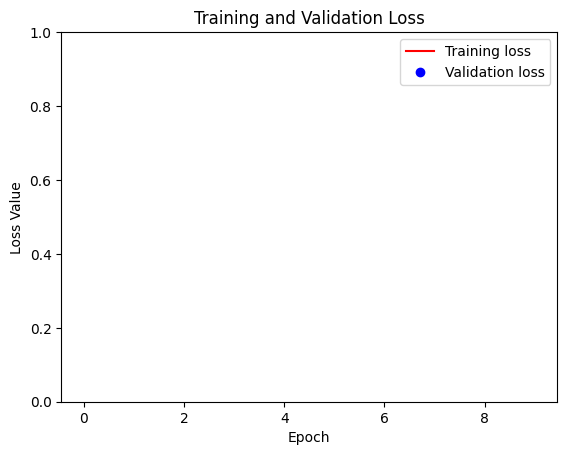

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 391ms/step


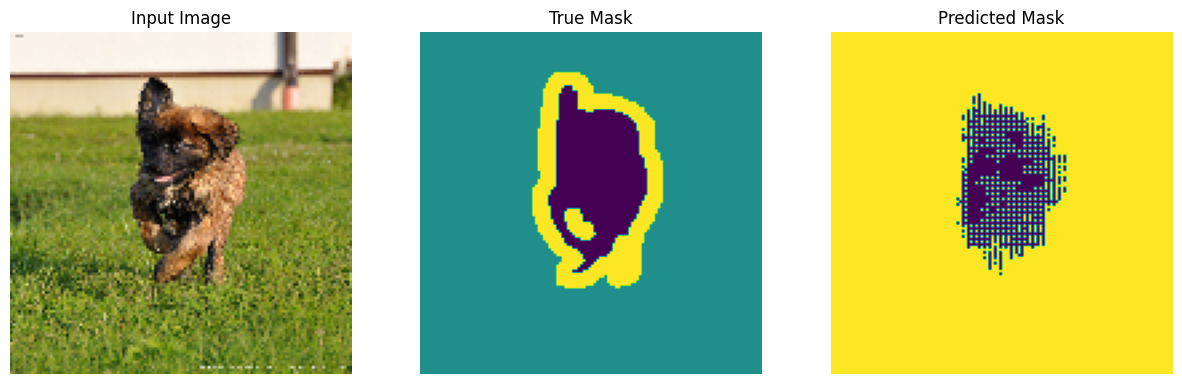

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 418ms/step


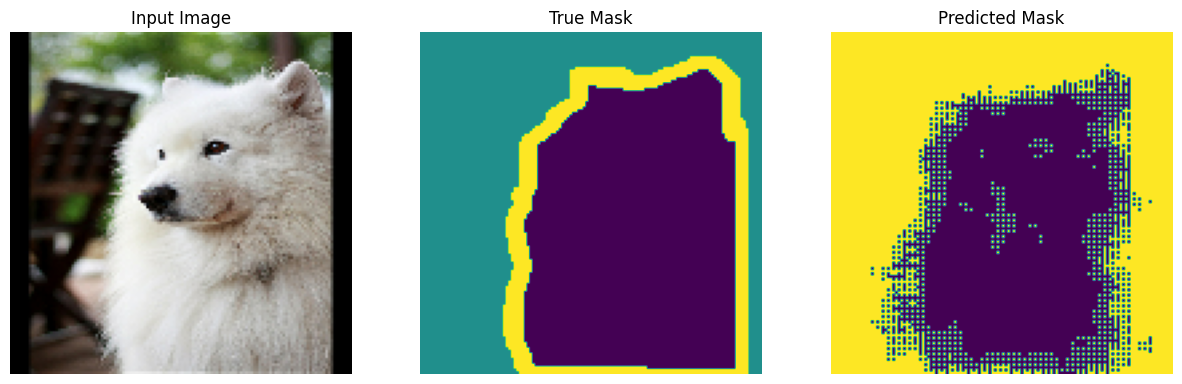

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step


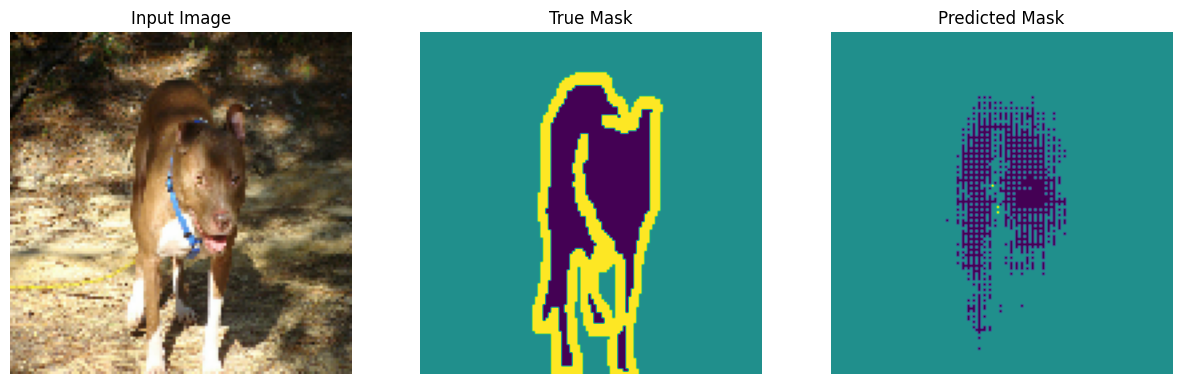

In [ ]:
# Make predictions
show_predictions(test_batches, 3)


In [ ]:
#Parte 2
#Opcional: clases desequilibradas y pesos de clase

try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")



Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.6677 - loss: 19.0613
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6834 - loss: 24.0732
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.6740 - loss: 22.7306
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.6398 - loss: 29.5082
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.6884 - loss: 13.5983
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6852 - loss: 18.7001
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7003 - loss: 21.0128
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.6903 - loss: 14.4139
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.7103 - loss: 13.4377
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.7009 - loss: 17.3720
Expected AssertionError: 


In [ ]:
#model fit


label = tf.constant([0, 0])  # Convertir la lista en un tensor constante
prediction = tf.constant([[-3., 0], [-3, 0]])  # Convertir la lista en un tensor constante
sample_weight = [1, 10]

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
loss_value = loss(label, prediction, sample_weight).numpy()

print(loss_value)

[ 3.0485873 30.485874 ]


In [ ]:
#Los elementos del conjunto de datos resultantes contienen 3 imágenes cada uno:

train_batches.map(add_sample_weights).element_spec

NameError: name 'train_batches' is not defined

In [ ]:

#Ahora puede entrenar un modelo en este conjunto de datos ponderado:

weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)